# environment setup

In [1]:
import torch

!git clone --recurse-submodules https://github.com/nerfstudio-project/gsplat.git
%cd gsplat
!BUILD_NO_CUDA=1 pip install -e .[dev]
!pip install -r examples/requirements.txt
!pip install ninja
!pip install wandb

Cloning into 'gsplat'...
remote: Enumerating objects: 3079, done.
remote: Counting objects: 100% (825/825), done.
remote: Compressing objects: 100% (234/234), done.
remote: Total 3079 (delta 672), reused 693 (delta 586), pack-reused 2254
Receiving objects: 100% (3079/3079), 83.50 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (2123/2123), done.
Submodule 'gsplat/cuda/csrc/third_party/glm' (https://github.com/g-truc/glm.git) registered for path 'gsplat/cuda/csrc/third_party/glm'
Cloning into '/content/gsplat/gsplat/cuda/csrc/third_party/glm'...
remote: Enumerating objects: 59610, done.        
remote: Total 59610 (delta 0), reused 0 (delta 0), pack-reused 59610        
Receiving objects: 100% (59610/59610), 71.19 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (45206/45206), done.
Submodule path 'gsplat/cuda/csrc/third_party/glm': checked out '47585fde0c49fa77a2bf2fb1d2ead06999fd4b6e'
/content/gsplat
Obtaining file:///content/gsplat
  Preparing metadata (setup.py) ... done
     ━━━━━━━

In [2]:
# test if the environment setup works

!python examples/simple_trainer.py

( ●    ) gsplat: Setting up CUDA (This may take a few minutes the first time)
Iteration 1/1000, Loss: 0.5653786063194275
Iteration 2/1000, Loss: 0.5584279298782349
Iteration 3/1000, Loss: 0.5529938340187073
Iteration 4/1000, Loss: 0.5483230352401733
Iteration 5/1000, Loss: 0.5437407493591309
Iteration 6/1000, Loss: 0.5393882989883423
Iteration 7/1000, Loss: 0.5352444648742676
Iteration 8/1000, Loss: 0.5306939482688904
Iteration 9/1000, Loss: 0.5263229012489319
Iteration 10/1000, Loss: 0.5218319892883301
Iteration 11/1000, Loss: 0.5173870325088501
Iteration 12/1000, Loss: 0.5129498243331909
Iteration 13/1000, Loss: 0.5083230137825012
Iteration 14/1000, Loss: 0.5034022927284241
Iteration 15/1000, Loss: 0.4986150860786438
Iteration 16/1000, Loss: 0.49352115392684937
Iteration 17/1000, Loss: 0.48832377791404724
Iteration 18/1000, Loss: 0.48313748836517334
Iteration 19/1000, Loss: 0.4775903820991516
Iteration 20/1000, Loss: 0.47208768129348755
Iteration 21/1000, Loss: 0.46636804938316345
It

# baseline

In [ ]:
%%writefile examples/simple_trainer_0227.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        mse_loss = torch.nn.MSELoss()
        frames = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                # return_alpha=True,
            )[..., :3]
            torch.cuda.synchronize()
            times[1] += time.time() - start
            loss = mse_loss(out_img, self.gt_image)
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                frames.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame) for frame in frames]
            out_dir = os.path.join(os.getcwd(), "renders")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/training.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

Writing examples/simple_trainer_0227.py


In [ ]:
!python examples/simple_trainer_0227.py --img_path /content/cat.jpg

wandb: Currently logged in as: gdj592 (summerproject). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.3
wandb: Run data is saved locally in /content/gsplat/wandb/run-20240227_151348-78nx436w
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run frosty-sea-32
wandb: ⭐️ View project at https://wandb.ai/summerproject/gs
wandb: 🚀 View run at https://wandb.ai/summerproject/gs/runs/78nx436w
/content/gsplat/examples/simple_trainer_0227.py:149: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)
Iteration 1/1000, Loss: 0.07934500277042389, PSNR: 11.00480447445835, SSMI: 0.778512179851532
/content/gsplat/examples/simple_trainer_0227.py:149: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. 

# rgba

In [ ]:
%%writefile examples/simple_trainer_rgba.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        mse_loss = torch.nn.MSELoss()
        frames_matted = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )
            torch.cuda.synchronize()
            times[1] += time.time() - start
            loss = mse_loss(out_img, self.gt_image)
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            out_dir = os.path.join(os.getcwd(), "renders")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/training_rgba.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

Overwriting examples/simple_trainer_rgba.py


In [ ]:
!python examples/simple_trainer_rgba.py --img_path /content/cat.jpg

wandb: Currently logged in as: gdj592 (summerproject). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.3
wandb: Run data is saved locally in /content/gsplat/wandb/run-20240227_121548-ctxbdjwe
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vocal-firebrand-14
wandb: ⭐️ View project at https://wandb.ai/summerproject/gs
wandb: 🚀 View run at https://wandb.ai/summerproject/gs/runs/ctxbdjwe
/content/gsplat/examples/simple_trainer_rgba.py:149: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)
Iteration 1/1000, Loss: 0.22202669084072113, PSNR: 6.535948087040069, SSMI: 0.5743111968040466
/content/gsplat/examples/simple_trainer_rgba.py:149: FutureWarning: `multichannel` is a deprecated argument name for `structural_similar

# learned_variance

In [ ]:
%%writefile examples/simple_trainer_learned_variance.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)
        self.learned_variance = torch.rand(self.num_points, d, device=self.device) # d=1

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.learned_variance.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.learned_variance, self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        gnll_loss = torch.nn.GaussianNLLLoss()
        frames_matted = []
        variance_map = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )

            # out_img = rasterize_gaussians(
            #    xys,
            #    depths,
            #    radii,
            #    conics,
            #    num_tiles_hit,
            #    torch.sigmoid(self.rgbs),
            #    torch.sigmoid(self.opacities),
            #    self.H,
            #    self.W,
            #    B_SIZE,
            #    self.background,
            #)

            out_un = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.learned_variance), # self.learned_variance.repeat(1, 3)
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
            )
            torch.cuda.synchronize()
            times[1] += time.time() - start
            learned_variance_mean = torch.mean(out_un, dim=2) # variance_map = out_un[:,0]; save as a .npy file
            # learned_variance_mean_normalized = learned_variance_mean / learned_variance_mean.abs().max()
            # breakpoint()
            loss = gnll_loss(out_img, self.gt_image, learned_variance_mean) + 4 #
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))
                # frames_matted.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
                variance_map.append((learned_variance_mean.detach().cpu().numpy() * 255).astype(np.uint8))
            # breakpoint()

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            # frames = [Image.fromarray(frame) for frame in frames_matted]
            variance_frames = [Image.fromarray(variance_frame, 'P') for variance_frame in variance_map]
            out_dir = os.path.join(os.getcwd(), "renders")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/training_rgba_gnll.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
            variance_frames[0].save(
                f"{out_dir}/training_variance.gif",
                save_all=True,
                append_images=variance_frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

Writing examples/simple_trainer_learned_variance.py


In [ ]:
!python examples/simple_trainer_learned_variance.py

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /content/gsplat/wandb/run-20240308_150813-25zqfqro
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run unique-monkey-66
wandb: ⭐️ View project at https://wandb.ai/summerproject/gs
wandb: 🚀 View run at https://wandb.ai/summerproject/gs/runs/25zqfqro
/content/gsplat/examples/simple_trainer_learned_variance.py:183: FutureWarning: `multichannel` is a deprecated argument name for `

In [ ]:
import numpy as np

img = np.random.rand(2, 2)
img_clipped = img.clip(0, 0.8 * img.max())

img, img_clipped

(array([[0.39901135, 0.68921218],
        [0.96675958, 0.37937516]]),
 array([[0.39901135, 0.68921218],
        [0.77340767, 0.37937516]]))

check more examples of images. get more test cases.

change the number of points. change from e.g. 4, 8, ..

# modified version

In [ ]:
%%writefile examples/simple_trainer_learned_variance_2.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)
        self.learned_variance = torch.rand(self.num_points, 1, device=self.device) # d=1

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.learned_variance.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.learned_variance, self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        gnll_loss = torch.nn.GaussianNLLLoss()
        frames_matted = []
        variance_map = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )

            # out_img = rasterize_gaussians(
            #    xys,
            #    depths,
            #    radii,
            #    conics,
            #    num_tiles_hit,
            #    torch.sigmoid(self.rgbs),
            #    torch.sigmoid(self.opacities),
            #    self.H,
            #    self.W,
            #    B_SIZE,
            #    self.background,
            #)

            out_un = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.learned_variance.repeat(1, 3)), # self.learned_variance.repeat(1, 3)
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
            )
            torch.cuda.synchronize()
            times[1] += time.time() - start
            learned_variance_mean = out_un[:, :, 0] # variance_map = out_un[:,0]; save as a .npy file
            # learned_variance_mean_normalized = learned_variance_mean / learned_variance_mean.abs().max()
            # breakpoint()
            loss = gnll_loss(out_img, self.gt_image, learned_variance_mean) + 4 #
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))
                # frames_matted.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
                variance_map.append((learned_variance_mean.detach().cpu().numpy() * 255).astype(np.uint8))
            # breakpoint()

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            # frames = [Image.fromarray(frame) for frame in frames_matted]
            variance_frames = [Image.fromarray(variance_frame, 'P') for variance_frame in variance_map]
            out_dir = os.path.join(os.getcwd(), "renders")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/training_rgba_gnll_2.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
            variance_frames[0].save(
                f"{out_dir}/training_variance_2.gif",
                save_all=True,
                append_images=variance_frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

Overwriting examples/simple_trainer_learned_variance_2.py


In [ ]:
!python examples/simple_trainer_learned_variance_2.py

wandb: Currently logged in as: gdj592 (summerproject). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /content/gsplat/wandb/run-20240308_151253-h1nwbnon
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cool-puddle-68
wandb: ⭐️ View project at https://wandb.ai/summerproject/gs
wandb: 🚀 View run at https://wandb.ai/summerproject/gs/runs/h1nwbnon
/content/gsplat/examples/simple_trainer_learned_variance_2.py:183: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)
Iteration 1/1000, Loss: 3.938661813735962, PSNR: 6.462725892464256, SSMI: 0.570728063583374
/content/gsplat/examples/simple_trainer_learned_variance_2.py:183: FutureWarning: `multichannel` is a deprecated argument name fo

In [ ]:
%%writefile examples/simple_trainer_learned_variance_3.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)
        self.learned_variance = torch.rand(self.num_points, 1, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.learned_variance.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.learned_variance, self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        gnll_loss = torch.nn.GaussianNLLLoss()
        frames_matted = []
        variance_map_frames = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )

            # out_img = rasterize_gaussians(
            #    xys,
            #    depths,
            #    radii,
            #    conics,
            #    num_tiles_hit,
            #    torch.sigmoid(self.rgbs),
            #    torch.sigmoid(self.opacities),
            #    self.H,
            #    self.W,
            #    B_SIZE,
            #    self.background,
            #)
            # breakpoint()
            out_un = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.learned_variance.repeat(1, 3)), # self.learned_variance.repeat(1, 3)
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
            )
            torch.cuda.synchronize()
            times[1] += time.time() - start
            # learned_variance_mean = torch.mean(out_un, dim=2)
            variance_map = torch.mean(out_un, dim=2)
            # variance_map = out_un[:, :, 2]  # save as a .npy file
            # learned_variance_mean_normalized = learned_variance_mean / learned_variance_mean.abs().max()
            # breakpoint()
            loss = gnll_loss(out_img, self.gt_image, variance_map) + 4 #
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))
                # frames_matted.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
                variance_map_frames.append((variance_map.detach().cpu().numpy() * 255).astype(np.uint8))
            # breakpoint()

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            # frames = [Image.fromarray(frame) for frame in frames_matted]
            variance_frames = [Image.fromarray(variance_frame, 'P') for variance_frame in variance_map_frames]
            out_dir = os.path.join(os.getcwd(), "renders")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/training_rgba_gnll_3.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
            variance_frames[0].save(
                f"{out_dir}/training_variance_3.gif",
                save_all=True,
                append_images=variance_frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

Overwriting examples/simple_trainer_learned_variance_3.py


In [ ]:
!python examples/simple_trainer_learned_variance_3.py

wandb: Currently logged in as: gdj592 (summerproject). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /content/gsplat/wandb/run-20240308_151624-lmfsl9h5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run whole-elevator-69
wandb: ⭐️ View project at https://wandb.ai/summerproject/gs
wandb: 🚀 View run at https://wandb.ai/summerproject/gs/runs/lmfsl9h5
/content/gsplat/examples/simple_trainer_learned_variance_3.py:185: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)
Iteration 1/1000, Loss: 3.9441492557525635, PSNR: 6.487446911326176, SSMI: 0.5729637742042542
/content/gsplat/examples/simple_trainer_learned_variance_3.py:185: FutureWarning: `multichannel` is a deprecated argument na

# Experiments

## experiment on Gaussian numbers

In [ ]:
%%writefile examples/simple_trainer_learned_variance_exp1.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)
        self.learned_variance = torch.rand(self.num_points, 1, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.learned_variance.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.learned_variance, self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        gnll_loss = torch.nn.GaussianNLLLoss()
        frames_matted = []
        variance_map_frames = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )

            # out_img = rasterize_gaussians(
            #    xys,
            #    depths,
            #    radii,
            #    conics,
            #    num_tiles_hit,
            #    torch.sigmoid(self.rgbs),
            #    torch.sigmoid(self.opacities),
            #    self.H,
            #    self.W,
            #    B_SIZE,
            #    self.background,
            #)
            # breakpoint()
            out_un = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.learned_variance.repeat(1, 3)), # self.learned_variance.repeat(1, 3)
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
            )
            torch.cuda.synchronize()
            times[1] += time.time() - start
            # learned_variance_mean = torch.mean(out_un, dim=2)
            variance_map = torch.mean(out_un, dim=2)
            # variance_map = out_un[:, :, 2]  # save as a .npy file
            # learned_variance_mean_normalized = learned_variance_mean / learned_variance_mean.abs().max()
            # breakpoint()
            loss = gnll_loss(out_img, self.gt_image, variance_map) + 4 #
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))
                # frames_matted.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
                variance_map_frames.append((variance_map.detach().cpu().numpy() * 255).astype(np.uint8))
            # breakpoint()

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            # frames = [Image.fromarray(frame) for frame in frames_matted]
            variance_frames = [Image.fromarray(variance_frame, 'P') for variance_frame in variance_map_frames]
            out_dir = os.path.join(os.getcwd(), "experiments/exp2")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/result_image_corridor.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
            variance_frames[0].save(
                f"{out_dir}/result_uncertainty_corridor.gif",
                save_all=True,
                append_images=variance_frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

Overwriting examples/simple_trainer_learned_variance_exp1.py


In [ ]:
!python examples/simple_trainer_learned_variance_exp1.py --num_points 10000 --img_path /content/corridor.jpg --save_imgs

wandb: Currently logged in as: gdj592 (summerproject). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /content/gsplat/wandb/run-20240309_173307-tud8c5fz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run deft-dust-107
wandb: ⭐️ View project at https://wandb.ai/summerproject/gs
wandb: 🚀 View run at https://wandb.ai/summerproject/gs/runs/tud8c5fz
/content/gsplat/examples/simple_trainer_learned_variance_exp1.py:185: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)
Iteration 1/1000, Loss: 3.8166637420654297, PSNR: 11.605146448009506, SSMI: 0.7483221888542175
/content/gsplat/examples/simple_trainer_learned_variance_exp1.py:185: FutureWarning: `multichannel` is a deprecated argument

## experiment on iteration times

In [ ]:
%%writefile examples/simple_iterations_exp2.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 1000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)
        self.learned_variance = torch.rand(self.num_points, 1, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.learned_variance.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 2000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.learned_variance, self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        gnll_loss = torch.nn.GaussianNLLLoss()
        frames_matted = []
        variance_map_frames = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )

            # out_img = rasterize_gaussians(
            #    xys,
            #    depths,
            #    radii,
            #    conics,
            #    num_tiles_hit,
            #    torch.sigmoid(self.rgbs),
            #    torch.sigmoid(self.opacities),
            #    self.H,
            #    self.W,
            #    B_SIZE,
            #    self.background,
            #)
            # breakpoint()
            out_un = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.learned_variance.repeat(1, 3)), # self.learned_variance.repeat(1, 3)
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
            )
            torch.cuda.synchronize()
            times[1] += time.time() - start
            # learned_variance_mean = torch.mean(out_un, dim=2)
            variance_map = torch.mean(out_un, dim=2)
            # variance_map = out_un[:, :, 2]  # save as a .npy file
            # learned_variance_mean_normalized = learned_variance_mean / learned_variance_mean.abs().max()
            # breakpoint()
            loss = gnll_loss(out_img, self.gt_image, variance_map) + 4 #
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))
                # frames_matted.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
                variance_map_frames.append((variance_map.detach().cpu().numpy() * 255).astype(np.uint8))
            # breakpoint()

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            # frames = [Image.fromarray(frame) for frame in frames_matted]
            variance_frames = [Image.fromarray(variance_frame, 'P') for variance_frame in variance_map_frames]
            out_dir = os.path.join(os.getcwd(), "experiments/exp2")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/result_image_corridor.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
            variance_frames[0].save(
                f"{out_dir}/result_uncertainty_corridor.gif",
                save_all=True,
                append_images=variance_frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

Writing examples/simple_iterations_exp2.py


## experiment on rasterizer rounds

In [ ]:
%%writefile examples/simple_trainer_raster_ensemble_exp2.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)
        self.learned_variance = torch.rand(self.num_points, 1, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.learned_variance.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.learned_variance, self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        gnll_loss = torch.nn.GaussianNLLLoss()
        frames_matted = []
        variance_map_frames = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )

            # out_img = rasterize_gaussians(
            #    xys,
            #    depths,
            #    radii,
            #    conics,
            #    num_tiles_hit,
            #    torch.sigmoid(self.rgbs),
            #    torch.sigmoid(self.opacities),
            #    self.H,
            #    self.W,
            #    B_SIZE,
            #    self.background,
            #)
            # breakpoint()

            ensemble_number = 10
            out_un_all = torch.zeros(out_img.shape)

            for i in range(0, ensemble_number):
                out_un = rasterize_gaussians(
                    xys,
                    depths,
                    radii,
                    conics,
                    num_tiles_hit,
                    torch.sigmoid(self.learned_variance.repeat(1, 3)), # self.learned_variance.repeat(1, 3)
                    torch.sigmoid(self.opacities),
                    self.H,
                    self.W,
                    B_SIZE,
                    self.background,
                )
                out_un_all.cat((out_un_all, out_un), dim=0)

            torch.cuda.synchronize()
            times[1] += time.time() - start
            # learned_variance_mean = torch.mean(out_un, dim=2)
            # variance_map = torch.mean(out_un, dim=2)
            variance_map = torch.mean(torch.mean(out_un_all[1:], ensemble_number - 1), 2)
            # variance_map = out_un[:, :, 2]  # save as a .npy file
            # learned_variance_mean_normalized = learned_variance_mean / learned_variance_mean.abs().max()
            # breakpoint()
            loss = gnll_loss(out_img, self.gt_image, variance_map) + 4 #
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))
                # frames_matted.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
                variance_map_frames.append((variance_map.detach().cpu().numpy() * 255).astype(np.uint8))
            # breakpoint()

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            # frames = [Image.fromarray(frame) for frame in frames_matted]
            variance_frames = [Image.fromarray(variance_frame, 'P') for variance_frame in variance_map_frames]
            out_dir = os.path.join(os.getcwd(), "experiments/exp2")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/result_image_corridor.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
            variance_frames[0].save(
                f"{out_dir}/result_uncertainty_corridor.gif",
                save_all=True,
                append_images=variance_frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

## tracking and clipping the variance

In [ ]:
%%writefile examples/simple_trainer_track_variance_exp4.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)
        self.learned_variance = torch.rand(self.num_points, 1, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.learned_variance.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.learned_variance, self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        gnll_loss = torch.nn.GaussianNLLLoss()
        frames_matted = []
        variance_map_frames = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )

            # out_img = rasterize_gaussians(
            #    xys,
            #    depths,
            #    radii,
            #    conics,
            #    num_tiles_hit,
            #    torch.sigmoid(self.rgbs),
            #    torch.sigmoid(self.opacities),
            #    self.H,
            #    self.W,
            #    B_SIZE,
            #    self.background,
            #)
            # breakpoint()
            out_un = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.learned_variance.repeat(1, 3)), # self.learned_variance.repeat(1, 3)
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
            )
            torch.cuda.synchronize()
            times[1] += time.time() - start
            # learned_variance_mean = torch.mean(out_un, dim=2)
            variance_map = torch.mean(out_un, dim=2) #clipped
            # variance_map = out_un[:, :, 2]  # save as a .npy file
            # learned_variance_mean_normalized = learned_variance_mean / learned_variance_mean.abs().max()
            # breakpoint()
            # loss = gnll_loss(out_img, self.gt_image, variance_map) + 4 #
            loss = gnll_loss(out_img, self.gt_image, variance_map) + 4
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))
                # frames_matted.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
                variance_map_frames.append((clipped_variance_map.detach().cpu().numpy() * 255).astype(np.uint8))
            # breakpoint()

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            # frames = [Image.fromarray(frame) for frame in frames_matted]
            variance_frames = [Image.fromarray(variance_frame, 'P') for variance_frame in variance_map_frames]
            out_dir = os.path.join(os.getcwd(), "experiments/exp4")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/result_image_hk.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
            variance_frames[0].save(
                f"{out_dir}/result_uncertainty_hk.gif",
                save_all=True,
                append_images=variance_frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

Overwriting examples/simple_trainer_track_variance_exp4.py


In [ ]:
!python examples/simple_trainer_track_variance_exp4.py --num_points 10000 --img_path /content/hk.jpg --save_imgs

wandb: Currently logged in as: gdj592 (summerproject). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /content/gsplat/wandb/run-20240311_142026-tt2z0ng9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rich-frog-121
wandb: ⭐️ View project at https://wandb.ai/summerproject/gs
wandb: 🚀 View run at https://wandb.ai/summerproject/gs/runs/tt2z0ng9
/content/gsplat/examples/simple_trainer_track_variance_exp4.py:186: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)
Iteration 1/1000, Loss: 3.8357598781585693, PSNR: 7.3913377284213855, SSMI: 0.41992127895355225
/content/gsplat/examples/simple_trainer_track_variance_exp4.py:186: FutureWarning: `multichannel` is a deprecated argument na

## visualize loss landscape

In [ ]:
%%writefile examples/loss_landscape.py

import math
import os
import time
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import tyro
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from PIL import Image
from torch import Tensor, optim

import wandb
import random

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)
        self.learned_variance = torch.rand(self.num_points, 1, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.learned_variance.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.learned_variance, self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        gnll_loss = torch.nn.GaussianNLLLoss()
        frames_matted = []
        variance_map_frames = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()
            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats,
                self.viewmat,
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )
            torch.cuda.synchronize()
            times[0] += time.time() - start
            start = time.time()
            out_img, out_alpha = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
                return_alpha=True,
            )

            # out_img = rasterize_gaussians(
            #    xys,
            #    depths,
            #    radii,
            #    conics,
            #    num_tiles_hit,
            #    torch.sigmoid(self.rgbs),
            #    torch.sigmoid(self.opacities),
            #    self.H,
            #    self.W,
            #    B_SIZE,
            #    self.background,
            #)
            # breakpoint()
            out_un = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.learned_variance.repeat(1, 3)), # self.learned_variance.repeat(1, 3)
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
            )
            torch.cuda.synchronize()
            times[1] += time.time() - start
            # learned_variance_mean = torch.mean(out_un, dim=2)
            variance_map = torch.mean(out_un, dim=2)
            # variance_map = out_un[:, :, 2]  # save as a .npy file
            # learned_variance_mean_normalized = learned_variance_mean / learned_variance_mean.abs().max()
            # breakpoint()
            loss = gnll_loss(out_img, self.gt_image, variance_map) + 4 #
            optimizer.zero_grad()
            start = time.time()

            # Compute PSNR and SSIM
            psnr_value = psnr(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy())
            # breakpoint()
            ssim_value = ssim(out_img.detach().cpu().numpy(), self.gt_image.detach().cpu().numpy(), multichannel=True)

            # log metrics to wandb
            wandb.log({"loss": loss, "psnr": psnr_value, "ssim": ssim_value})

            loss.backward()
            torch.cuda.synchronize()
            times[2] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}, PSNR: {psnr_value.item()}, SSMI: {ssim_value.item()}")

            if save_imgs and iter % 5 == 0:
                out = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)
                frames_matted.append((out.detach().cpu().numpy() * 255).astype(np.uint8))
                # frames_matted.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
                variance_map_frames.append((variance_map.detach().cpu().numpy() * 255).astype(np.uint8))
            # breakpoint()

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame, 'RGBA') for frame in frames_matted]
            # frames = [Image.fromarray(frame) for frame in frames_matted]
            variance_frames = [Image.fromarray(variance_frame, 'P') for variance_frame in variance_map_frames]
            out_dir = os.path.join(os.getcwd(), "experiments/exp2")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/result_image_corridor.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
            variance_frames[0].save(
                f"{out_dir}/result_uncertainty_corridor.gif",
                save_all=True,
                append_images=variance_frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(
            f"Total(s):\nProject: {times[0]:.3f}, Rasterize: {times[1]:.3f}, Backward: {times[2]:.3f}"
        )
        print(
            f"Per step(s):\nProject: {times[0]/iterations:.5f}, Rasterize: {times[1]/iterations:.5f}, Backward: {times[2]/iterations:.5f}"
        )


def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    # Initialize wandb
    wandb.init(project="gs", config={"lr": lr, "iterations": iterations})

    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

    # Finish the wandb run
    wandb.finish()


if __name__ == "__main__":
    tyro.cli(main)

# Details

## getting gt image

In [ ]:
# get input data - gt image

height: int = 256
width: int = 256
num_points: int = 100000
save_imgs: bool = True
iterations: int = 1000
lr: float = 0.01

gt_image = torch.ones((height, width, 3)) * 1.0
# make top left and bottom right red, blue
gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

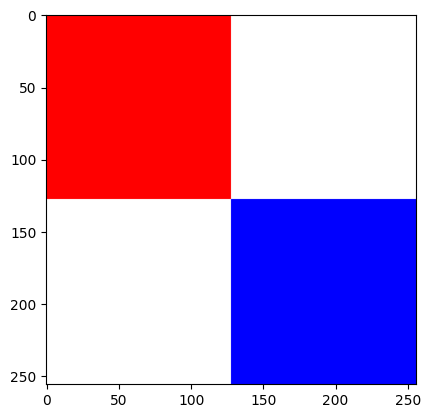

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(gt_image)

## getting random gaussians

In [ ]:
from examples.simple_trainer import SimpleTrainer
from gsplat.rasterize import *
from gsplat.project_gaussians import *

In [ ]:
trainer = SimpleTrainer(gt_image)

trainer

In [ ]:
trainer.means.shape, trainer.scales.shape, trainer.rgbs.shape, trainer.quats.shape, trainer.opacities.shape, trainer.viewmat.shape, trainer.background.shape

(torch.Size([2000, 3]),
 torch.Size([2000, 3]),
 torch.Size([2000, 3]),
 torch.Size([2000, 4]),
 torch.Size([2000, 1]),
 torch.Size([4, 4]),
 torch.Size([3]))

In [ ]:
trainer.opacities

tensor([[0.7630],
        [0.8318],
        [1.3341],
        ...,
        [2.8623],
        [0.5939],
        [2.7294]], device='cuda:0', requires_grad=True)

In [ ]:
# attribute "uncertainty" should be added here - while getting random gaussians.

from examples.simple_trainer_u import SimpleTrainer_u

trainer_u = SimpleTrainer_u(gt_image)

trainer_u.means.shape, trainer_u.scales.shape, trainer_u.rgbs.shape, trainer_u.quats.shape, trainer_u.opacities.shape, trainer_u.uncertainties.shape, trainer_u.viewmat.shape, trainer_u.background.shape

(torch.Size([2000, 3]),
 torch.Size([2000, 3]),
 torch.Size([2000, 3]),
 torch.Size([2000, 4]),
 torch.Size([2000, 1]),
 torch.Size([2000, 1]),
 torch.Size([4, 4]),
 torch.Size([3]))

## training loop

let's first have a look at what is without training.
### projection

In [ ]:
B_SIZE: int = 14

xys, depths, radii, conics, compensation, num_tiles_hit, cov3d = project_gaussians(
                trainer.means,
                trainer.scales,
                1,
                trainer.quats,
                trainer.viewmat,
                trainer.viewmat,
                trainer.focal,
                trainer.focal,
                trainer.W / 2,
                trainer.H / 2,
                trainer.H,
                trainer.W,
                B_SIZE,
            )

In [ ]:
# using training_u

B_SIZE: int = 14

xys_u, depths_u, radii_u, conics_u, compensation_u, num_tiles_hit_u, cov3d_u = project_gaussians(
                trainer_u.means,
                trainer_u.scales,
                1,
                trainer_u.quats,
                trainer_u.viewmat,
                trainer_u.viewmat,
                trainer_u.focal,
                trainer_u.focal,
                trainer_u.W / 2,
                trainer_u.H / 2,
                trainer_u.H,
                trainer_u.W,
                B_SIZE,
            )

In [ ]:
xys.shape, depths.shape, radii.shape, conics.shape, compensation.shape, num_tiles_hit.shape, cov3d.shape

(torch.Size([2000, 2]),
 torch.Size([2000]),
 torch.Size([2000]),
 torch.Size([2000, 3]),
 torch.Size([2000]),
 torch.Size([2000]),
 torch.Size([2000, 6]))

In [ ]:
xys_u.shape, depths_u.shape, radii_u.shape, conics_u.shape, compensation_u.shape, num_tiles_hit_u.shape, cov3d_u.shape

(torch.Size([2000, 2]),
 torch.Size([2000]),
 torch.Size([2000]),
 torch.Size([2000, 3]),
 torch.Size([2000]),
 torch.Size([2000]),
 torch.Size([2000, 6]))

In [ ]:
# uncertainties = torch.nn.Parameter(torch.ones(2000, 1))

# uncertainties.shape

torch.Size([2000, 1])

In [ ]:
# # copy uncertainty to three channels

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# uncertainties_3d = torch.nn.Parameter(torch.ones(2000, 3))

# uncertainties_3d.to(device)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0', grad_fn=<ToCopyBackward0>)

### rasterization

In [ ]:
out_img =  rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(trainer.rgbs),
                torch.sigmoid(trainer.opacities),
                trainer.H,
                trainer.W,
                B_SIZE,
                trainer.background,
            )[..., :3]

In [ ]:
out_img_u =  rasterize_gaussians(
                xys_u,
                depths_u,
                radii_u,
                conics_u,
                num_tiles_hit_u,
                torch.sigmoid(trainer_u.rgbs),
                torch.sigmoid(trainer_u.opacities),
                trainer_u.H,
                trainer_u.W,
                B_SIZE,
                trainer_u.background,
            )[..., :3]

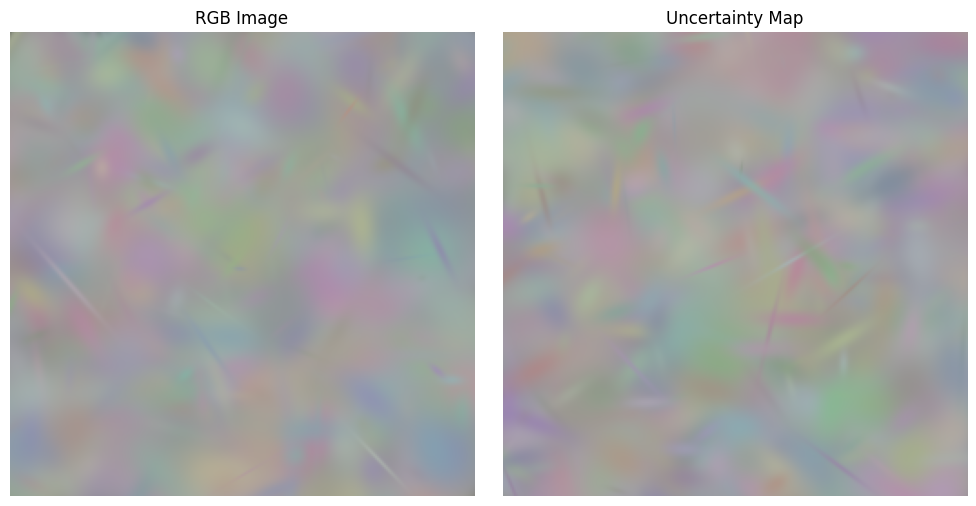

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(out_img.detach().cpu().numpy())
axs[0].set_title('RGB Image')
axs[0].axis('off')

axs[1].imshow(out_img_u.detach().cpu().numpy(), cmap='gray')
axs[1].set_title('Uncertainty Map')
axs[1].axis('off')

plt.tight_layout()

plt.show()

### propogation

rgba

In [ ]:
from PIL import Image

img1 = Image.new('RGBA', (100, 100), (255, 0, 0, 0))
img2 = Image.new('RGBA', (100, 100), (100, 155, 0, 0))
img3 = Image.new('RGBA', (100, 100), (0, 255, 100, 0))

img_seq = [img1, img2, img3]


In [ ]:
!pwd

/content/gsplat


In [ ]:
img_seq[0].save(
                f"/content/test.gif",
                save_all=True,
                append_images=img_seq[1:],
                optimize=False,
                duration=5,
                loop=0,
            )

In [ ]:
out_img = torch.rand((256, 256, 3))
out_alpha = torch.rand((256, 256))

In [ ]:
out_alpha.unsqueeze(2).shape

torch.Size([256, 256, 1])

In [ ]:
tens = torch.cat((out_img, out_alpha.unsqueeze(2)), 2)

tens.shape

torch.Size([256, 256, 4])